# NOAA Multi-Radar / Multi-Sensor System (MRMS) Ingest 

The [NOAA Multi-Radar / Multi-Sensor System (MRMS)](https://www.nssl.noaa.gov/projects/mrms/) was created to produce products of preciptiation impacts on transportation and aviation. 

Using the [NOAA MRMS AWS Bucket](https://aws.amazon.com/marketplace/pp/prodview-6odvdc4md2jjc), this notebook details creation of quicklooks to investigate multisensor (radar, rain gauge, etc) precipitation estimates for Chicago. 

In [1]:
import cfgrib
import xarray as xr
import fsspec
import glob
import tempfile
import io
import gzip
import geopandas as gpd
import pandas as pd
import numpy as np

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.img_tiles import GoogleTiles, OSM
from matplotlib.transforms import offset_copy
from matplotlib import pyplot as plt

from metpy.plots import USCOUNTIES

import cmweather

In [2]:
# Define a Date for Analysis [YYYYMMDD format]
DATE = "20241101"

In [3]:
## Setup the AWS S3 filesystem
fs = fsspec.filesystem("s3", anon=True)

## Selecting the Desired MRMS Product

In [4]:
file_path = sorted(fs.glob(f"s3://noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/{DATE}/*"))

In [5]:
file_path

['noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-000000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-010000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-020000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-030000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-040000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-050000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-060000.grib2.gz',
 'noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-07

In [6]:
with fs.open(file_path[-2], 'rb') as gzip_file:
    print(gzip_file)
    #compressed_file = gzip_file.read()
    #compressed_file = io.BytesIO(gzip_file)
    #print(compressed_file)
    with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
        f.write(gzip.decompress(gzip_file.read()))
        xx = xr.load_dataset(f.name)

<File-like object S3FileSystem, noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-220000.grib2.gz>


In [7]:
xx

<xarray.Dataset> Size: 98MB
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 8B 2024-11-01T22:00:00
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      datetime64[ns] 8B 2024-11-01T22:00:00
Data variables:
    unknown         (latitude, longitude) float32 98MB 0.0 0.0 0.0 ... -3.0 -3.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2024-11-19T17:36 GRIB to CDM+CF via cfgrib-0.9.1...

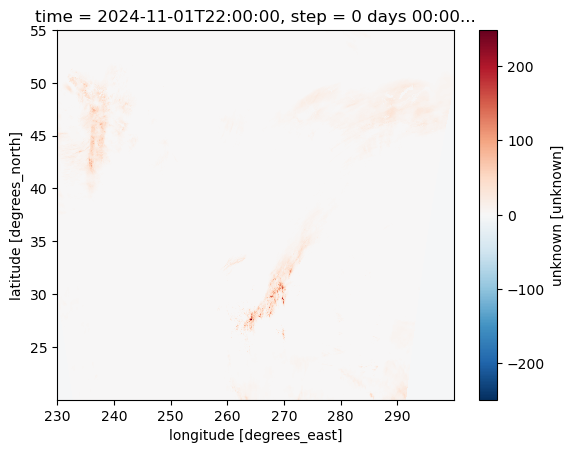

In [8]:
xx.unknown.plot()

In [9]:
xx

<xarray.Dataset> Size: 98MB
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 8B 2024-11-01T22:00:00
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      datetime64[ns] 8B 2024-11-01T22:00:00
Data variables:
    unknown         (latitude, longitude) float32 98MB 0.0 0.0 0.0 ... -3.0 -3.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2024-11-19T17:36 GRIB to CDM+CF via cfgrib-0.9.1...

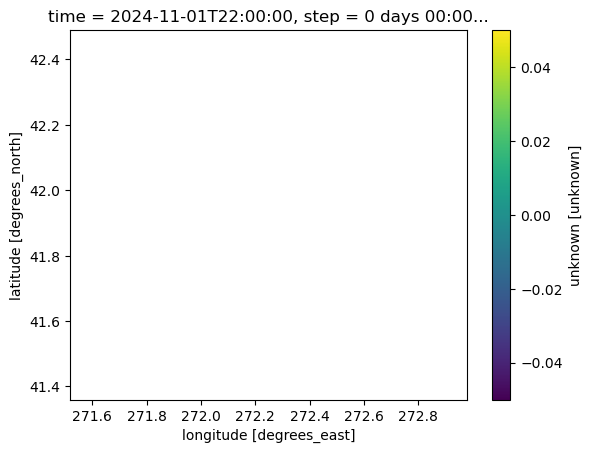

In [10]:
xx.sel(latitude=slice(42.493302, 41.356063), longitude=slice(271.52, 272.98)).where(xx.unknown > 0).unknown.plot()

## Chicago Domain Function

In [11]:
# Site attributes
global_NEIU = {'conventions': "CF 1.10",
               'site_ID' : "NEIU",
               'CAMS_tag' : "CMS-WXT-002",
               'datastream' : "CMS_wxt536_NEIU_a1",
               'datalevel' : "a1",
               "wxt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
               "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
               'WSN' : 'W08D',
               'latitude' : 41.9804526,
               'longitude' : -87.7196038}
    
global_NU = {'conventions': "CF 1.10",
             'WSN':'W099',
             'site_ID' : "NU",
             'CAMS_tag' : "CMS-WXT-005",
             'datastream' : "CMS_wxt536_NU_a1",
             'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
             "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
             'datalevel' : "a1",
             'latitude' : 42.051469749,
             'longitude' : -87.677667183}
    
global_CSU = {'conventions': "CF 1.10",
              'WSN':'W08E',
              'site_ID' : "CSU",
              'CAMS_tag' : "CMS-WXT-003",
              'datastream' : "CMS_wxt536_CSU_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.71991216,
              'longitude' : -87.612834722}
    
global_UIC = {'conventions': "CF 1.10",
              'WSN':'W096',
              'site_ID' : "UIC",
              'CAMS_tag' : "CMS-WXT-006",
              'datastream' : "CMS_wxt536_UIC_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.86943346,
              'longitude' : -87.645871814}
    
global_ATMOS = {'conventions': "CF 1.10",
                'WSN':'W0A4',
                'site_ID' : "ATMOS",
                'CAMS_tag' : "CMS-WXT-001",
                'datastream' : "CMS_wxt536_ATMOS_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.701556533,
                'longitude' : -87.99507543}
    
global_ADM = {'conventions': "CF 1.10",
              'WSN':'W09E',
              'site_ID' : "ADM",
              'CAMS_tag' : "CMS-WXT-013",
              'datastream' : "CMS_wxt536_ADM_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.867571129,
              'longitude' : -87.649593711}

global_CCICS = {'conventions': "CF 1.10",
                'WSN':'W08B',
                'site_ID' : "CCICS",
                'CAMS_tag' : "CMS-WXT-099",
                'datastream' : "CMS_wxt536_CCICS_a1",
                'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
                "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
                'datalevel' : "a1",
                'latitude' : 41.822953674,
                'longitude' : -87.609452418}

global_WWL = {"conventions": "CF 1.10",
              "WSN" : "W0A0",
              "site_ID": "WWL",
              "CAMS_tag": "CMS-WXT-008",
              'datastream' : "CMS_wxt536_CCICS_a1",
              'wxt-plugin' : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.*",
              "aqt-plugin" : "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.*",
              'datalevel' : "a1",
              'latitude' : 41.77699,
              'longitude' : -87.60972}
    
#put these in a dictionary for accessing
global_sites = {'NU' : global_NU, 
                'CSU': global_CSU,
                'NEIU' : global_NEIU,
                'UIC' : global_UIC,
                'ATMOS' : global_ATMOS,
                'CCICS' : global_CCICS,
                'WWL' : global_WWL}

In [12]:
def mrms_qpe(nfile, global_sites):
    """
    Create a display to visualize MRMS Composite Reflectivity across
     the Chicago-CROCUS domain, marking locations of the node. 

    Input
    -----
    nfile - GRIB2 file (uncompressed)
        MRMS multi-sensor qpe grib2 file, which has been uncompressed

    global_sites : dict
        Information that are specific to the CROCUS sites.

    Returns
    -------
    axarr : Matplotlib.pyplot Figure 
        Figure instance containing the desired quicklook; to be saved outside 
        of function
    """
    
    # Read in the MRMS CREF file
    mrms = xr.load_dataset(nfile, engine="cfgrib")

    # Rename the dependent variable from unknown
    mrms = mrms.rename({'unknown' : 'multisensor_qpe_pass2'})

    # Define CREF attributes
    mrms["multisensor_qpe_pass2"].attrs["units"] = "mm"
    mrms["multisensor_qpe_pass2"].attrs["long_name"] = "Precipitation Accumulation"

    # Subset the data
    sdata = mrms.sel(latitude=slice(42.5, 41.5), longitude=slice(271.5, 273)).where(mrms.multisensor_qpe_pass2 > 0)

    # Set up the figure
    fig = plt.figure(figsize=(16, 8))
    # Initialize OpenStreetMap tile
    tiler = OSM()
    # Create a subplot and define projection
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # plot the CREF, making sure to transform for the projection
    # make sure to set the alpha to not obscure the street map beneath
    sdata.multisensor_qpe_pass2.plot(transform=ccrs.PlateCarree(), 
                                     ax=ax,
                                     alpha=0.78,
                                     vmin=0.1,
                                     cmap="ChaseSpectral")
    
    # Add some various map elements to the plot to make it recognizable.
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_image(tiler, 11)
    ax.gridlines(draw_labels=True)

    # Set CROCUS - Chicago Domain bounds
    ax.set_extent([271.9, 272.5, 41.6, 42.15])

    # Display the CROCUS node location and tags
    for key in global_sites:
        ax.plot(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                marker='o', 
                color='black', 
                markersize=10, 
                alpha=0.7, 
                transform=ccrs.PlateCarree())

        # Use the cartopy interface to create a matplotlib transform object
        # for the Geodetic coordinate system. We will use this along with
        # matplotlib's offset_copy function to define a coordinate system which
        # translates the text by 25 pixels to the left.
        # note - taken from cartopy examples
        geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

        # Add text 25 pixels to the left of the volcano.
        ax.text(global_sites[key]['longitude'], 
                global_sites[key]['latitude'], 
                global_sites[key]['site_ID'], 
                verticalalignment='center', 
                horizontalalignment='right', 
                transform=text_transform,
                bbox=dict(facecolor='sandybrown', 
                alpha=0.5, 
                boxstyle='round'))
        
    # update the title of the display
    ax.set_title(np.datetime_as_string(sdata['valid_time'].data, unit='s').replace("T", " - ") + 
                 "Z\n" + "24 hr Multi-sensor Precipitation Accumulation")

    # free up memory
    del mrms, sdata, tiler

    return ax

<File-like object S3FileSystem, noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-140000.grib2.gz>


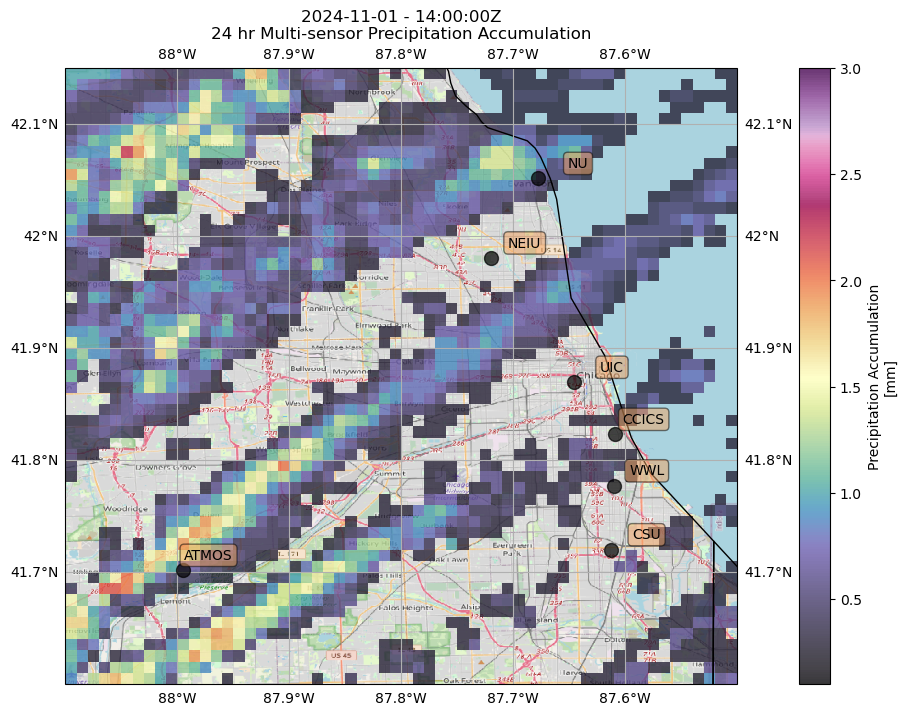

In [13]:
with fs.open(file_path[-10], 'rb') as gzip_file:
    print(gzip_file)
    with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
        f.write(gzip.decompress(gzip_file.read()))
        mrms_qpe(f.name, global_sites)

## Overlay the CoCoRaHS data

In [14]:
DATE

'20241101'

In [15]:
date_selection = DATE[4:6] + '/' + DATE[-2:] + '/' + DATE[0:4]
print(date_selection)

11/01/2024


In [16]:
date_selection = DATE[4:6] + '/' + DATE[-2:] + '/' + DATE[0:4]
file_sat2 = f'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=CK&ReportDateType=reportdate&Date={date_selection}&TimesInGMT=True'

In [17]:
file_sat2

'http://data.cocorahs.org/export/exportreports.aspx?ReportType=Daily&dtf=1&Format=CSV&State=IL&County=CK&ReportDateType=reportdate&Date=11/01/2024&TimesInGMT=True'

In [18]:
df = pd.read_csv(file_sat2)

In [19]:
df

,ObservationDate,ObservationTime,EntryDateTime,StationNumber,StationName,Latitude,Longitude,TotalPrecipAmt,NewSnowDepth,NewSnowSWE,TotalSnowDepth,TotalSnowSWE,DateTimeStamp
0,2024-11-01,12:30 PM,2024-11-01 12:29 PM,IL-CK-12,Bridgeview 1.3 NNW,41.755015,-87.817285,0.01,NA,NA,NA,NA,2024-11-01 12:29 PM
1,2024-11-01,12:00 PM,2024-11-01 06:30 PM,IL-CK-42,Mount Prospect 3.0 NE,42.096184,-87.896703,0.01,0.0,NA,0.0,NA,2024-11-01 06:30 PM
2,2024-11-01,10:00 AM,2024-11-04 01:04 PM,IL-CK-50,Palos Park 1.3 SW,41.652814,-87.863067,0.00,0.0,NA,NA,NA,2024-11-04 01:04 PM
3,2024-11-01,01:36 PM,2024-11-01 01:42 PM,IL-CK-53,Glencoe 0.1 NW,42.135650,-87.765394,T,NA,NA,NA,NA,2024-11-01 01:42 PM
4,2024-11-01,12:00 PM,2024-11-01 12:27 PM,IL-CK-63,Elk Grove Village 0.6 ESE,42.003899,-87.981309,0.02,NA,NA,NA,NA,2024-11-01 12:27 PM
5,2024-11-01,12:00 PM,2024-11-01 01:32 PM,IL-CK-64,Homewood 0.1 ESE,41.557694,-87.659444,0.03,NA,NA,NA,NA,2024-11-01 01:32 PM
6,2024-11-01,12:00 PM,2024-11-01 01:22 PM,IL-CK-69,Park Forest 0.8 NNE,41.492800,-87.681489,0.05,NA,NA,NA,NA,2024-11-01 01:22 PM
7,2024-11-01,11:25 AM,2024-11-01 11:29 AM,IL-CK-74,Oak Park 1.3 NNE,41.906214,-87.781880,0.02,0.0,NA,NA,NA,2024-11-01 11:28 AM
8,2024-11-01,12:15 PM,2024-11-01 12:26 PM,IL-CK-75,Elk Grove Village 2.2 WSW,41.995258,-88.052741,0.05,NA,NA,NA,NA,2024-11-01 12:26 PM
9,2024-11-01,01:00 PM,2024-11-02 11:22 PM,IL-CK-211,Oak Lawn 1.6 WNW,41.726860,-87.777733,T,NA,NA,NA,NA,2024-11-02 11:21 PM


In [20]:
for row in df.itertuples():
    print(row.Latitude, row.Longitude, row.TotalPrecipAmt)

41.755015 -87.817285  0.01
42.096184 -87.896703  0.01
41.652814 -87.863067  0.00
42.13565 -87.765394  T
42.003899 -87.981309  0.02
41.557694 -87.659444  0.03
41.4928 -87.681489  0.05
41.906214 -87.78188  0.02
41.995258 -88.052741  0.05
41.72686005 -87.77773285  T
41.5318909 -87.664093  0.02
42.01676 -87.855668  0.01
42.113853 -88.017779  0.00
41.67684 -87.911415  0.10
42.048122 -88.116188  0.04
42.0043 -87.6697  0.00
42.001874 -87.69847  T
41.995667 -87.691833  T
41.708447 -87.753872  T
42.0511 -87.8097  0.02
41.701767 -87.781987  0.03
41.971546 -87.803251  0.01
41.822576 -87.875805  0.06
41.6726 -87.7181  0.03
41.693577 -87.728993  T
41.682451 -87.792025  0.01
42.029123 -87.692574  0.02
41.6155 -87.7507  0.02
42.067523 -87.935838  0.02
41.945698 -87.733337  0.02
42.04309 -87.6792  0.03
42.030278 -88.043989  0.06
42.095697 -87.7788529  0.01
41.829457 -87.783805  0.01
42.03303 -87.69777  0.04
42.081944 -87.997116  0.06
42.130082 -88.026691  0.01
41.980278 -87.717083  0.01
41.87373410791

In [21]:
with fs.open(file_path[-10], 'rb') as gzip_file:
    print(gzip_file)
    with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
        f.write(gzip.decompress(gzip_file.read()))
        #mrms_qpe(f.name, global_sites)
        mrms = xr.load_dataset(f.name, engine="cfgrib")

<File-like object S3FileSystem, noaa-mrms-pds/CONUS/MultiSensor_QPE_24H_Pass2_00.00/20241101/MRMS_MultiSensor_QPE_24H_Pass2_00.00_20241101-140000.grib2.gz>


Text(0.5, 1.0, '2024-11-01 - 14:00:00Z\n24 hr Multi-sensor Precipitation Accumulation')

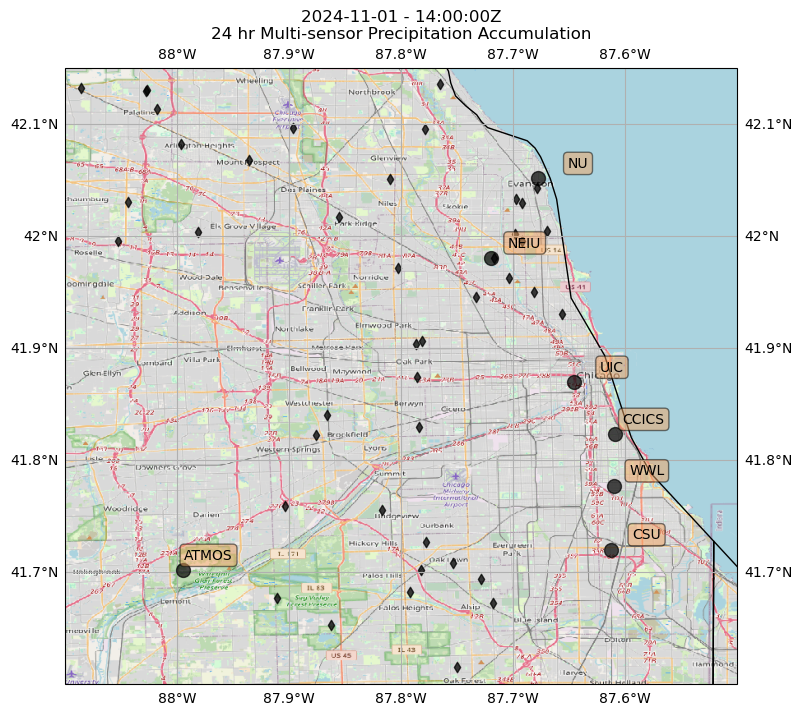

In [22]:
# Read in the MRMS CREF file
##mrms = xr.load_dataset(nfile, engine="cfgrib")

# Rename the dependent variable from unknown
mrms = mrms.rename({'unknown' : 'multisensor_qpe_pass2'})

# Define CREF attributes
mrms["multisensor_qpe_pass2"].attrs["units"] = "mm"
mrms["multisensor_qpe_pass2"].attrs["long_name"] = "Precipitation Accumulation"

# Subset the data
sdata = mrms.sel(latitude=slice(42.5, 41.5), longitude=slice(271.5, 273)).where(mrms.multisensor_qpe_pass2 > 0)

# Set up the figure
fig = plt.figure(figsize=(16, 8))
# Initialize OpenStreetMap tile
tiler = OSM()
# Create a subplot and define projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
 
# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 11)
ax.gridlines(draw_labels=True)

# Set CROCUS - Chicago Domain bounds
ax.set_extent([271.9, 272.5, 41.6, 42.15])

# -------------
# CROCUS Sites
# -------------
# Display the CROCUS node location and tags
for key in global_sites:
    ax.plot(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    # note - taken from cartopy examples
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # Add text 25 pixels to the left of the volcano.
    ax.text(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            global_sites[key]['site_ID'], 
            verticalalignment='center', 
            horizontalalignment='right', 
            transform=text_transform,
            bbox=dict(facecolor='sandybrown', 
            alpha=0.5, 
            boxstyle='round'))
    
# ---------
# CoCoRaHS
# ---------
joe = 0
for row in df.itertuples():
    #ax.text(row.Latitude, 
    #        row.Longitude, 
    #        row.TotalPrecipAmt,
    #        transform=ccrs.PlateCarree())
    ax.scatter(x=row.Longitude,
               y=row.Latitude,
               color="black",
               s=28,
               alpha=0.75,
               marker='d',
               transform=ccrs.PlateCarree()
              )
          
# update the title of the display
ax.set_title(np.datetime_as_string(sdata['valid_time'].data, unit='s').replace("T", " - ") + 
             "Z\n" + "24 hr Multi-sensor Precipitation Accumulation")

# Set CROCUS - Chicago Domain bounds
#ax.set_extent([271.9, 272.5, 41.6, 42.15])

In [24]:
type(df)

pandas.core.frame.DataFrame

In [37]:
df

,ObservationDate,ObservationTime,EntryDateTime,StationNumber,StationName,Latitude,Longitude,TotalPrecipAmt,NewSnowDepth,NewSnowSWE,TotalSnowDepth,TotalSnowSWE,DateTimeStamp
0,2024-11-01,12:30 PM,2024-11-01 12:29 PM,IL-CK-12,Bridgeview 1.3 NNW,41.755015,-87.817285,0.01,NA,NA,NA,NA,2024-11-01 12:29 PM
1,2024-11-01,12:00 PM,2024-11-01 06:30 PM,IL-CK-42,Mount Prospect 3.0 NE,42.096184,-87.896703,0.01,0.0,NA,0.0,NA,2024-11-01 06:30 PM
2,2024-11-01,10:00 AM,2024-11-04 01:04 PM,IL-CK-50,Palos Park 1.3 SW,41.652814,-87.863067,0.00,0.0,NA,NA,NA,2024-11-04 01:04 PM
3,2024-11-01,01:36 PM,2024-11-01 01:42 PM,IL-CK-53,Glencoe 0.1 NW,42.135650,-87.765394,T,NA,NA,NA,NA,2024-11-01 01:42 PM
4,2024-11-01,12:00 PM,2024-11-01 12:27 PM,IL-CK-63,Elk Grove Village 0.6 ESE,42.003899,-87.981309,0.02,NA,NA,NA,NA,2024-11-01 12:27 PM
5,2024-11-01,12:00 PM,2024-11-01 01:32 PM,IL-CK-64,Homewood 0.1 ESE,41.557694,-87.659444,0.03,NA,NA,NA,NA,2024-11-01 01:32 PM
6,2024-11-01,12:00 PM,2024-11-01 01:22 PM,IL-CK-69,Park Forest 0.8 NNE,41.492800,-87.681489,0.05,NA,NA,NA,NA,2024-11-01 01:22 PM
7,2024-11-01,11:25 AM,2024-11-01 11:29 AM,IL-CK-74,Oak Park 1.3 NNE,41.906214,-87.781880,0.02,0.0,NA,NA,NA,2024-11-01 11:28 AM
8,2024-11-01,12:15 PM,2024-11-01 12:26 PM,IL-CK-75,Elk Grove Village 2.2 WSW,41.995258,-88.052741,0.05,NA,NA,NA,NA,2024-11-01 12:26 PM
9,2024-11-01,01:00 PM,2024-11-02 11:22 PM,IL-CK-211,Oak Lawn 1.6 WNW,41.726860,-87.777733,T,NA,NA,NA,NA,2024-11-02 11:21 PM


In [41]:
df['TotalPrecipAmt'] = df['TotalPrecipAmt'].replace(' T', ' 0.001')

In [43]:
df['TotalPrecipAmt']

0       0.01
1       0.01
2       0.00
3      0.001
4       0.02
5       0.03
6       0.05
7       0.02
8       0.05
9      0.001
10      0.02
11      0.01
12      0.00
13      0.10
14      0.04
15      0.00
16     0.001
17     0.001
18     0.001
19      0.02
20      0.03
21      0.01
22      0.06
23      0.03
24     0.001
25      0.01
26      0.02
27      0.02
28      0.02
29      0.02
30      0.03
31      0.06
32      0.01
33      0.01
34      0.04
35      0.06
36      0.01
37      0.01
38      0.04
39      0.00
40      0.04
41      0.01
42      0.10
43      0.02
44      0.03
45      0.02
46      0.02
47      0.03
48      0.00
49      0.02
50      0.00
51      0.00
Name: TotalPrecipAmt, dtype: object

In [44]:
joe = df.to_xarray()

In [45]:
joe

<xarray.Dataset> Size: 6kB
Dimensions:          (index: 52)
Coordinates:
  * index            (index) int64 416B 0 1 2 3 4 5 6 7 ... 45 46 47 48 49 50 51
Data variables: (12/13)
    ObservationDate  (index) object 416B '2024-11-01' ... '2024-11-01'
    ObservationTime  (index) object 416B ' 12:30 PM' ' 12:00 PM' ... ' 12:30 PM'
    EntryDateTime    (index) object 416B ' 2024-11-01 12:29 PM' ... ' 2024-11...
    StationNumber    (index) object 416B ' IL-CK-12' ... ' IL-CK-320'
    StationName      (index) object 416B ' Bridgeview 1.3 NNW' ... ' Park For...
    Latitude         (index) float64 416B 41.76 42.1 41.65 ... 41.93 41.84 41.49
    ...               ...
    TotalPrecipAmt   (index) object 416B ' 0.01' ' 0.01' ... ' 0.00' ' 0.00'
    NewSnowDepth     (index) object 416B ' NA' ' 0.0' ' 0.0' ... ' 0.0' ' 0.0'
    NewSnowSWE       (index) object 416B ' NA' ' NA' ' NA' ... ' NA' ' 0.00'
    TotalSnowDepth   (index) object 416B ' NA' ' 0.0' ' NA' ... ' NA' ' 0.0'
    TotalSnowSWE     (index) object 416B ' NA' ' NA' ' NA' ... ' NA' ' 0.00'
    DateTimeStamp    (index) object 416B ' 2024-11-01 12:29 PM' ... ' 2024-11...

In [31]:
joe.Latitude

<xarray.DataArray 'Latitude' (index: 52)> Size: 416B
array([41.755015  , 42.096184  , 41.652814  , 42.13565   , 42.003899  ,
       41.557694  , 41.4928    , 41.906214  , 41.995258  , 41.72686005,
       41.5318909 , 42.01676   , 42.113853  , 41.67684   , 42.048122  ,
       42.0043    , 42.001874  , 41.995667  , 41.708447  , 42.0511    ,
       41.701767  , 41.971546  , 41.822576  , 41.6726    , 41.693577  ,
       41.682451  , 42.029123  , 41.6155    , 42.067523  , 41.945698  ,
       42.04309   , 42.030278  , 42.095697  , 41.829457  , 42.03303   ,
       42.081944  , 42.130082  , 41.980278  , 41.87373411, 41.568898  ,
       42.0986    , 42.131893  , 41.542771  , 41.758549  , 41.9625    ,
       41.903234  , 41.95025   , 41.510573  , 42.129876  , 41.930228  ,
       41.840267  , 41.48579   ])
Coordinates:
  * index    (index) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51

In [32]:
joe.Longitude

<xarray.DataArray 'Longitude' (index: 52)> Size: 416B
array([-87.817285  , -87.896703  , -87.863067  , -87.765394  ,
       -87.981309  , -87.659444  , -87.681489  , -87.78188   ,
       -88.052741  , -87.77773285, -87.664093  , -87.855668  ,
       -88.017779  , -87.911415  , -88.116188  , -87.6697    ,
       -87.69847   , -87.691833  , -87.753872  , -87.8097    ,
       -87.781987  , -87.803251  , -87.875805  , -87.7181    ,
       -87.728993  , -87.792025  , -87.692574  , -87.7507    ,
       -87.935838  , -87.733337  , -87.6792    , -88.043989  ,
       -87.7788529 , -87.783805  , -87.69777   , -87.997116  ,
       -88.026691  , -87.717083  , -87.78567686, -87.781407  ,
       -88.1231    , -88.085665  , -87.654073  , -87.903976  ,
       -87.70425   , -87.787253  , -87.681513  , -87.720298  ,
       -88.028033  , -87.656567  , -87.866127  , -87.69962   ])
Coordinates:
  * index    (index) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51

In [46]:
joe.TotalPrecipAmt

<xarray.DataArray 'TotalPrecipAmt' (index: 52)> Size: 416B
array([' 0.01', ' 0.01', ' 0.00', ' 0.001', ' 0.02', ' 0.03', ' 0.05',
       ' 0.02', ' 0.05', ' 0.001', ' 0.02', ' 0.01', ' 0.00', ' 0.10',
       ' 0.04', ' 0.00', ' 0.001', ' 0.001', ' 0.001', ' 0.02', ' 0.03',
       ' 0.01', ' 0.06', ' 0.03', ' 0.001', ' 0.01', ' 0.02', ' 0.02',
       ' 0.02', ' 0.02', ' 0.03', ' 0.06', ' 0.01', ' 0.01', ' 0.04',
       ' 0.06', ' 0.01', ' 0.01', ' 0.04', ' 0.00', ' 0.04', ' 0.01',
       ' 0.10', ' 0.02', ' 0.03', ' 0.02', ' 0.02', ' 0.03', ' 0.00',
       ' 0.02', ' 0.00', ' 0.00'], dtype=object)
Coordinates:
  * index    (index) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51

In [51]:
joe.TotalPrecipAmt.data = joe.TotalPrecipAmt.data.astype(float) * 100

In [52]:
joe.TotalPrecipAmt

<xarray.DataArray 'TotalPrecipAmt' (index: 52)> Size: 416B
array([ 1. ,  1. ,  0. ,  0.1,  2. ,  3. ,  5. ,  2. ,  5. ,  0.1,  2. ,
        1. ,  0. , 10. ,  4. ,  0. ,  0.1,  0.1,  0.1,  2. ,  3. ,  1. ,
        6. ,  3. ,  0.1,  1. ,  2. ,  2. ,  2. ,  2. ,  3. ,  6. ,  1. ,
        1. ,  4. ,  6. ,  1. ,  1. ,  4. ,  0. ,  4. ,  1. , 10. ,  2. ,
        3. ,  2. ,  2. ,  3. ,  0. ,  2. ,  0. ,  0. ])
Coordinates:
  * index    (index) int64 416B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50 51

TypeError: Input z must be 2D, not 1D

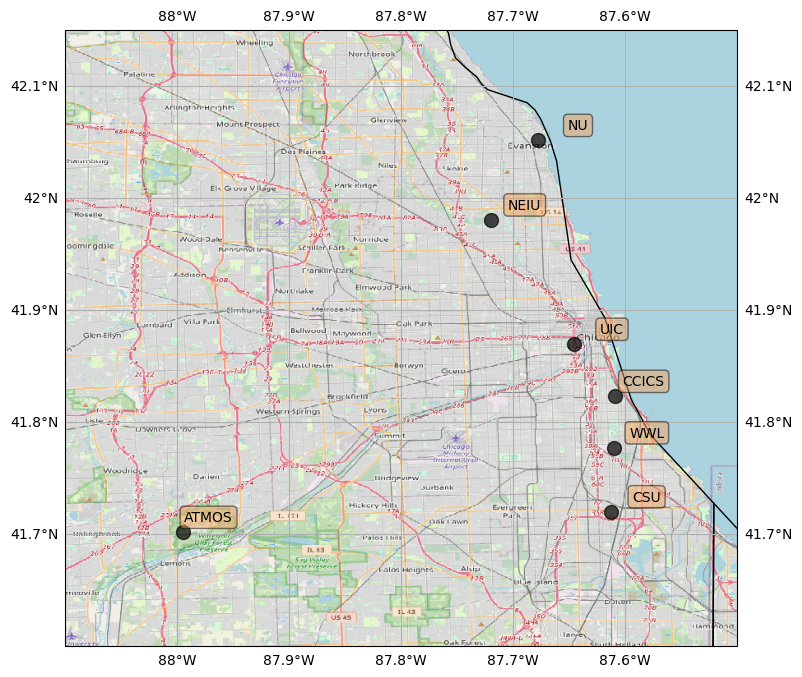

In [ ]:
# Set up the figure
fig = plt.figure(figsize=(16, 8))
# Initialize OpenStreetMap tile
tiler = OSM()
# Create a subplot and define projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
 
# Add some various map elements to the plot to make it recognizable.
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_image(tiler, 11)
ax.gridlines(draw_labels=True)

# Set CROCUS - Chicago Domain bounds
ax.set_extent([271.9, 272.5, 41.6, 42.15])

# -------------
# CROCUS Sites
# -------------
# Display the CROCUS node location and tags
for key in global_sites:
    ax.plot(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            marker='o', 
            color='black', 
            markersize=10, 
            alpha=0.7, 
            transform=ccrs.PlateCarree())

    # Use the cartopy interface to create a matplotlib transform object
    # for the Geodetic coordinate system. We will use this along with
    # matplotlib's offset_copy function to define a coordinate system which
    # translates the text by 25 pixels to the left.
    # note - taken from cartopy examples
    geodetic_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    text_transform = offset_copy(geodetic_transform, units='dots', x=+50, y=+15)

    # Add text 25 pixels to the left of the volcano.
    ax.text(global_sites[key]['longitude'], 
            global_sites[key]['latitude'], 
            global_sites[key]['site_ID'], 
            verticalalignment='center', 
            horizontalalignment='right', 
            transform=text_transform,
            bbox=dict(facecolor='sandybrown', 
            alpha=0.5, 
            boxstyle='round'))
    
# ---------
# CoCoRaHS
# ---------
nhatches = [None, '/', '\\', ".", '*']
cs = ax.contour(joe.Latitude, 
                joe.Longitude, 
                np.meshgrid(joe.TotalPrecipAmt, 
                levels=5, 
                hatches=nhatches,
                color=None,
                extend="lower",
                transform=ccrs.PlateCarree())

# create a legend for the CoCoRaHS
artists, labels = cs.legend_elements(str_format='{:2.1f}'.format)
ax.legend(artists, labels, handleheight=2, framealpha=1)
          
# update the title of the display
ax.set_title(np.datetime_as_string(sdata['valid_time'].data, unit='s').replace("T", " - ") + 
             "Z\n" + "24 hr Multi-sensor Precipitation Accumulation")

# Set CROCUS - Chicago Domain bounds
#ax.set_extent([271.9, 272.5, 41.6, 42.15])